In [1]:
# import packages
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
import pandas as pd
import pyreadr
import os
import pickle5 as pickle
import h5py

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity as cosine

In [2]:
os.chdir('C:\\Users\\Simon\\Desktop\\MA\\session-rec')

In [32]:
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
font = {'size': 18, 'weight': 'bold'}
%matplotlib inline

In [15]:
folder_figures = '../MA/figures/'

### setup

In [4]:
# create/load app and category mapping
data = pyreadr.read_r('../data/sequences_all_anon.Rds')[None]
data.rename(columns={'datum':'date', 'value':'category', 'anon_apps.name':'app_name'}, inplace=True)
data['timestamp'] = data['date'].apply(lambda x: x.timestamp())
data.loc[data['app_name'].isnull(),'app_name'] = data['category'] # replace NaNs in app_name by corresponding category value
data['sessionID'] = data['app_name'].shift(1).isin(['OFF_LOCKED','OFF_UNLOCKED']).cumsum() + 1 # sessionID is like sequence_number but does NOT start anew for each user

app_mapping = dict([(y,x+1) for x,y in enumerate(sorted(set(data['app_name'])))])
app_mapping_reverse = dict((v,k) for k,v in app_mapping.items())

with open('../data/app-level/category_mapping.pickle', 'rb') as handle:
    category_mapping = pickle.load(handle)

### helper functions

In [5]:
# helper function returning index of most similar app i.t.o. cosine similarity of app embedding
def max_cos_sim(x, ys, ignore=[]):
    max_cos = 0
    max_y = None
    max_i = None
    for i in range(len(ys)):
        y = ys[i]
        cos = cosine(x.reshape(1,-1), y.reshape(1,-1))
        if cos > max_cos:
            if not np.array_equal(x, y) and i not in ignore:
                max_cos = cos
                max_y = y
                max_i = i
#     return (max_cos, max_y, max_i)
    return max_i

In [6]:
def create_embedding_df(embeddings, indexes, embs, app_mapping_reverse, category_mapping, max_cos_sim):
    
    df = pd.DataFrame()
    df['embedding'] = embeddings.tolist()
    df['embedding'] = df['embedding'].apply(lambda x: np.array(x))
    df['x'] = embs[:, 0]
    df['y'] = embs[:, 1]
    df['appID'] = indexes
    df['app_name'] = df['appID'].apply(lambda x: app_mapping_reverse[x])
    df['app_category'] = df['app_name'].apply(lambda x: category_mapping[x])
    df['max_similarity_id'] = df['embedding'].apply(lambda x: max_cos_sim(x, df['embedding']))
    df['max_similarity_cat'] = df['max_similarity_id'].apply(lambda x: df['app_category'].iloc[x])
    
    return df

### create embedding dictionary

In [7]:
folder_in = 'results/testing/app-level/single/'
files = [f for f in os.listdir(folder_in) if f.endswith('.h5')]
embeddings_dict = {}
for file in files:
    embedding_size = file.split('_')[2]
    with h5py.File(folder_in + file, 'r') as hf:
        embeddings = hf['embeddings'][:]
        indexes = hf['indexes'][:]
    embeddings_dict[embedding_size] = {
        'embeddings': embeddings,
        'indexes': indexes
    }

### analysis for embedding size 128

In [8]:
embedding_size = '128'
embeddings = embeddings_dict[embedding_size]['embeddings']
indexes = embeddings_dict[embedding_size]['indexes']

In [9]:
# TSNE
tsne = TSNE(random_state=1, n_iter=1000, metric="cosine")
embs = tsne.fit_transform(embeddings)

In [10]:
df = create_embedding_df(embeddings, indexes, embs, app_mapping_reverse, category_mapping, max_cos_sim)

##### embedding visualization (TSNE)

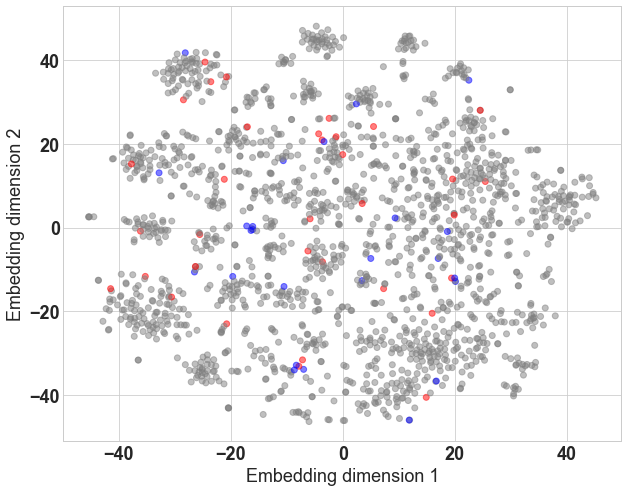

In [33]:
# plot of app categories using reduced 2D app embeddings
colors = {'Messaging':'blue', 'Social_Networks':'red'}
c = df['app_category'].map(colors).replace(np.nan, 'grey', regex=True)

fig_name = 'embeddings_clusters'
matplotlib.rc('font', **font)
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)

ax.scatter(embs[:, 0], embs[:, 1], alpha=.5, c=c)
plt.xlabel('Embedding dimension 1')
plt.ylabel('Embedding dimension 2')
# plt.legend(loc="upper left")

plt.savefig(folder_figures + fig_name + '.png', format = 'png', dpi=300)

# label = 'Messaging'
# df.loc[df['app_name'].apply(lambda x: x.startswith(label)), 'labels'] = label
# df['labels'].replace(np.nan, '', regex=True, inplace=True)
# FS = (10, 8)
# fig, ax = plt.subplots(figsize=FS)
# ax.scatter(embs[:, 0], embs[:, 1], alpha=.1)
# for i, label in enumerate(df['labels']):
#     plt.annotate(label, (df['x'][i], df['y'][i]))

##### embedding clustering (k-means)

In [34]:
# k-means for original embedding data
from sklearn.cluster import KMeans
km = KMeans(
    n_clusters=15, init='random',
    n_init=100, max_iter=500, 
    tol=1e-04, random_state=1
)

k_m = km.fit_predict(embeddings)
df['k_m'] = k_m

In [35]:
colors = {
    0: 'purple',
    1: 'red',
    2: 'green',
    3: 'blue',
    4: 'yellow',
    5: 'black',
    6: 'white',
    7: 'grey',
    8: 'orange',
    9: 'aqua',
    10: 'brown',
    11: 'lightgrey',
    12: 'darkgreen',
    13: 'pink',
    14: 'moccasin'
}

c = df['k_m'].map(colors)

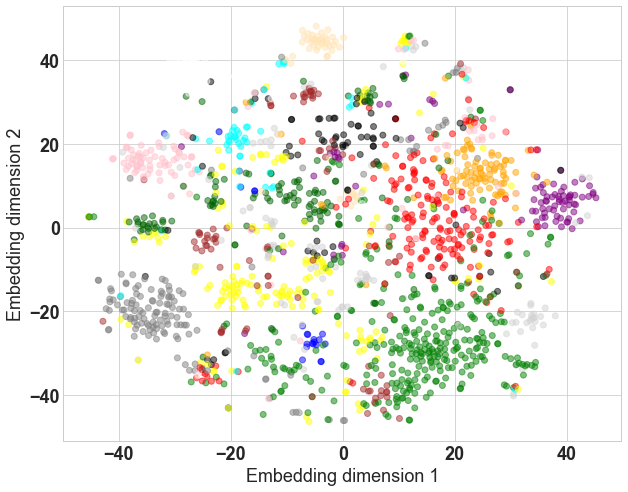

In [36]:
# 2D visual illustration of clusters
fig_name = 'embeddings_clusters_kmeans'
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=FS)
ax.scatter(embs[:, 0], embs[:, 1], alpha=.5, c=c)
plt.xlabel('Embedding dimension 1')
plt.ylabel('Embedding dimension 2')

plt.savefig(folder_figures + fig_name + '.png', format = 'png', dpi=300)

In [100]:
for i in range(15):
    res = df.loc[df.k_m == i].app_category.value_counts()
    print(i)
    print(res)

0
System_App                20
Tools                     13
Personalization            8
Checkup_Monitoring         6
Security                   5
Health_SelfMonitoring      4
Music_Audio_Radio          4
Organisation               3
Sharing_Cloud              3
Settings                   2
Calling                    2
Education                  2
Shopping                   1
Fake_Apps                  1
SHUTDOWN                   1
Gaming_Action              1
Workout                    1
Provider_Services          1
Gaming_Casual              1
Gaming_Knowledge           1
Orientation                1
Entertainment              1
Private_Transportation     1
Emergency_Warning          1
OFF_UNLOCKED               1
Gaming_Tools_Community     1
Gaming_Adventure           1
Sports                     1
Financial                  1
Name: app_category, dtype: int64
1
Gaming_Casual              17
Financial                  15
Gaming_Logic               13
Shopping                   10
To

In [101]:
# df.groupby(['k_m'])['app_category'].value_counts()[:50]

##### app similarity and analogy

In [102]:
# percentage of apps whose category coincides with category of most similar app
sum(df['max_similarity_cat'] == df['app_category'])/df.shape[0]

0.11673375503162738

##### analogy

In [103]:
analogies = [['Messaging_1', 'Social_Networks_1', 'Social_Networks_2'], ['Messaging_1', 'Launcher_1', 'Launcher_22'],
             ['Messaging_1', 'Internet_Browser_1', 'Internet_Browser_2'], ['Launcher_1', 'Social_Networks_1', 'Social_Networks_2'],
             ['Messaging_1', 'Music_Audio_Radio_1', 'Messaging_10'], ['Social_Networks_1', 'Social_Networks_2', 'Social_Networks_4'],
             ['Messaging_1', 'Messaging_2', 'Messaging_3'], ['Internet_Browser_1', 'Internet_Browser_2', 'Internet_Browser_3'],
             ['Orientation_1', 'Messaging_1', 'Messaging_2'], ['Messaging_1', 'Calling_27', 'Calling_35']]

In [104]:
for analogy in analogies:
    ignore = [df.loc[df['app_name'] == a].index.values.astype(int)[0] for a in analogy]
    x = df['embedding'][ignore[0]] - df['embedding'][ignore[1]] + df['embedding'][ignore[2]]
    ys = df['embedding']
    ind = max_cos_sim(x, ys, ignore=ignore)
    print(df['app_category'][ind])

Social_Networks
Language_Learning
News_Magazines
System_App
Tools
Dating_Mating
News_Magazines
Workout
Social_Networks
Health_SelfMonitoring


In [105]:
apps_by_freq = [x for x in data.app_name.value_counts().index if x in set(df.app_name)]

In [106]:
all_colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

In [107]:
# assign colors to k most frequent apps
k = 10

all_colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors = {}
for i in range(k):
    colors[apps_by_freq[i]] = list(all_colors.keys())[i]

c = df['app_name'].map(colors).replace(np.nan, 'lightgrey', regex=True)

<function matplotlib.pyplot.show(close=None, block=None)>

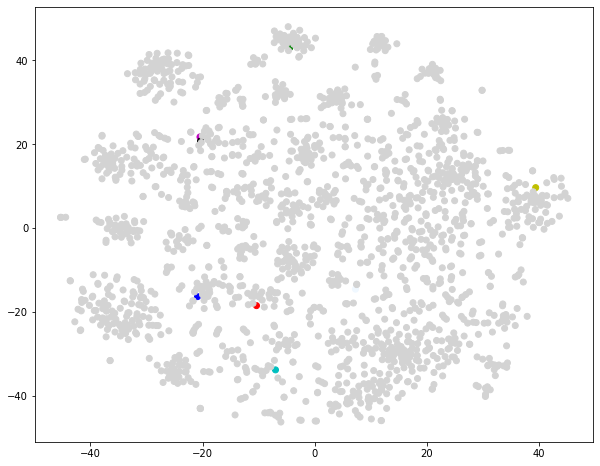

In [108]:
# plot of k most frequent apps
# fig_name = 'embeddings_clusters'

FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)

ax.scatter(embs[:, 0], embs[:, 1], alpha=1, c=c)

plt.show()

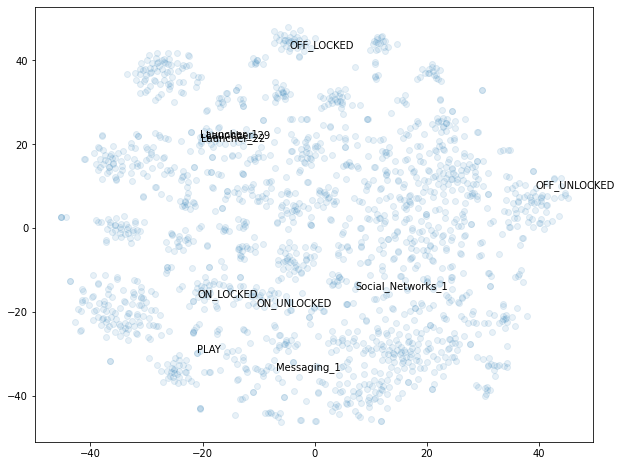

In [109]:
# plot with names of k most frequent apps
mask = df['app_name'].isin(apps_by_freq[:k])
df['labels'] = df['app_name'][mask]
df['labels'].replace(np.nan, '', regex=True, inplace=True)
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
ax.scatter(embs[:, 0], embs[:, 1], alpha=.1)
for i, label in enumerate(df['labels']):
    plt.annotate(label, (df['x'][i], df['y'][i]))

### analysis for embedding size 32

In [110]:
embedding_size = '32'
embeddings = embeddings_dict[embedding_size]['embeddings']
indexes = embeddings_dict[embedding_size]['indexes']

In [111]:
# TSNE
tsne = TSNE(random_state=1, n_iter=1000, metric="cosine")
embs = tsne.fit_transform(embeddings)

In [112]:
df = create_embedding_df(embeddings, indexes, embs, app_mapping_reverse, category_mapping, max_cos_sim)

##### embedding visualization (TSNE)

<function matplotlib.pyplot.show(close=None, block=None)>

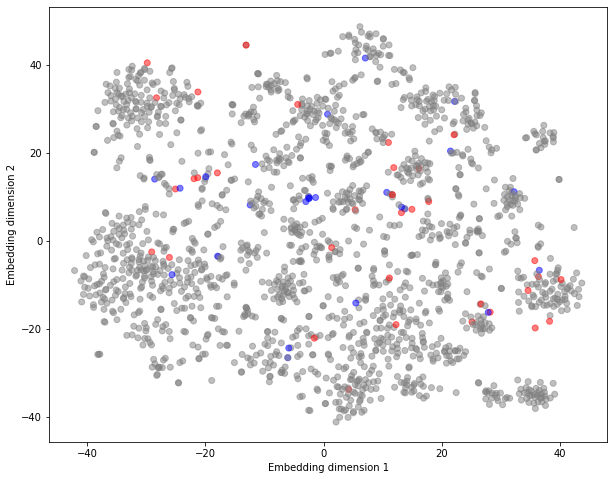

In [113]:
# plot of app categories using reduced 2D app embeddings
colors = {'Messaging':'blue', 'Social_Networks':'red'}
c = df['app_category'].map(colors).replace(np.nan, 'grey', regex=True)

FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)

ax.scatter(embs[:, 0], embs[:, 1], alpha=.5, c=c)
plt.xlabel('Embedding dimension 1')
plt.ylabel('Embedding dimension 2')
# plt.legend(loc="upper left")

plt.show

# label = 'Messaging'
# df.loc[df['app_name'].apply(lambda x: x.startswith(label)), 'labels'] = label
# df['labels'].replace(np.nan, '', regex=True, inplace=True)
# FS = (10, 8)
# fig, ax = plt.subplots(figsize=FS)
# ax.scatter(embs[:, 0], embs[:, 1], alpha=.1)
# for i, label in enumerate(df['labels']):
#     plt.annotate(label, (df['x'][i], df['y'][i]))

##### embedding clustering (k-means)

In [114]:
# k-means for original embedding data
from sklearn.cluster import KMeans
km = KMeans(
    n_clusters=15, init='random',
    n_init=100, max_iter=500, 
    tol=1e-04, random_state=1
)

k_m = km.fit_predict(embeddings)
df['k_m'] = k_m

In [115]:
colors = {
    0: 'purple',
    1: 'red',
    2: 'green',
    3: 'blue',
    4: 'yellow',
    5: 'black',
    6: 'white',
    7: 'grey',
    8: 'orange',
    9: 'aqua',
    10: 'brown',
    11: 'lightgrey',
    12: 'darkgreen',
    13: 'pink',
    14: 'moccasin'
}

c = df['k_m'].map(colors)

Text(0, 0.5, 'Embedding dimension 2')

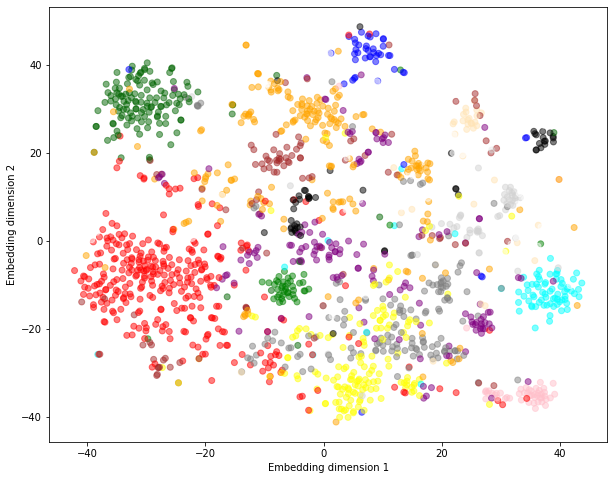

In [116]:
# 2D visual illustration of clusters
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
ax.scatter(embs[:, 0], embs[:, 1], alpha=.5, c=c)
plt.xlabel('Embedding dimension 1')
plt.ylabel('Embedding dimension 2')

In [117]:
for i in range(15):
    res = df.loc[df.k_m == i].app_category.value_counts()
    print(i)
    print(res)

0
Tools                      14
Language_Learning          12
Music_Audio_Radio           9
System_App                  7
Sport_News                  6
Gaming_Casual               6
Organisation                4
Note_Apps                   4
Financial                   4
TVVideo_Apps                4
Social_Networks             4
Sharing_Cloud               4
Office_Tools                4
Image_And_Video_Editing     3
Education                   3
Shopping                    3
Gaming_Simulation           3
Health_SelfMonitoring       3
Security                    3
Weather                     3
Eating                      3
Orientation                 3
Checkup_Monitoring          2
Entertainment               2
Activism_Charity            2
Provider_Services           2
News_Magazines              2
Gaming_Knowledge            2
ComicsBooks                 2
Settings                    2
Travel                      2
Shop_Sell_Rent              2
Shared_Transportation       2
Personal

In [118]:
# df.groupby(['k_m'])['app_category'].value_counts()[:50]

##### app similarity and analogy

In [119]:
# percentage of apps whose category coincides with category of most similar app
sum(df['max_similarity_cat'] == df['app_category'])/df.shape[0]

0.1144335825186889

##### analogy

In [120]:
analogies = [['Messaging_1', 'Social_Networks_1', 'Social_Networks_2'], ['Messaging_1', 'Launcher_1', 'Launcher_22'],
             ['Messaging_1', 'Internet_Browser_1', 'Internet_Browser_2'], ['Launcher_1', 'Social_Networks_1', 'Social_Networks_2'],
             ['Messaging_1', 'Music_Audio_Radio_1', 'Messaging_10'], ['Social_Networks_1', 'Social_Networks_2', 'Social_Networks_4'],
             ['Messaging_1', 'Messaging_2', 'Messaging_3'], ['Internet_Browser_1', 'Internet_Browser_2', 'Internet_Browser_3'],
             ['Orientation_1', 'Messaging_1', 'Messaging_2'], ['Messaging_1', 'Calling_27', 'Calling_35']]

In [121]:
for analogy in analogies:
    ignore = [df.loc[df['app_name'] == a].index.values.astype(int)[0] for a in analogy]
    x = df['embedding'][ignore[0]] - df['embedding'][ignore[1]] + df['embedding'][ignore[2]]
    ys = df['embedding']
    ind = max_cos_sim(x, ys, ignore=ignore)
    print(df['app_category'][ind])

Office_Tools
Note_Apps
News_Magazines
Activism_Charity
Womens_Apps
Gaming_Casual
ComicsBooks
TVVideo_Apps
Gaming_Casual
Language_Learning


In [122]:
apps_by_freq = [x for x in data.app_name.value_counts().index if x in set(df.app_name)]

In [123]:
all_colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

In [83]:
# assign colors to k most frequent apps
k = 10

all_colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors = {}
for i in range(k):
    colors[apps_by_freq[i]] = list(all_colors.keys())[i]

c = df['app_name'].map(colors).replace(np.nan, 'lightgrey', regex=True)

<function matplotlib.pyplot.show(close=None, block=None)>

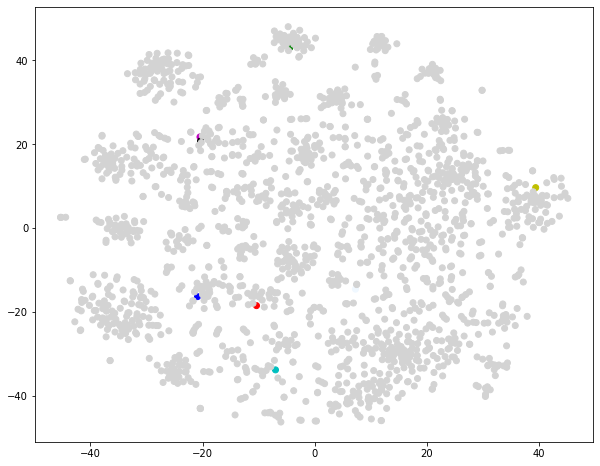

In [84]:
# plot of k most frequent apps
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)

ax.scatter(embs[:, 0], embs[:, 1], alpha=1, c=c)

plt.show

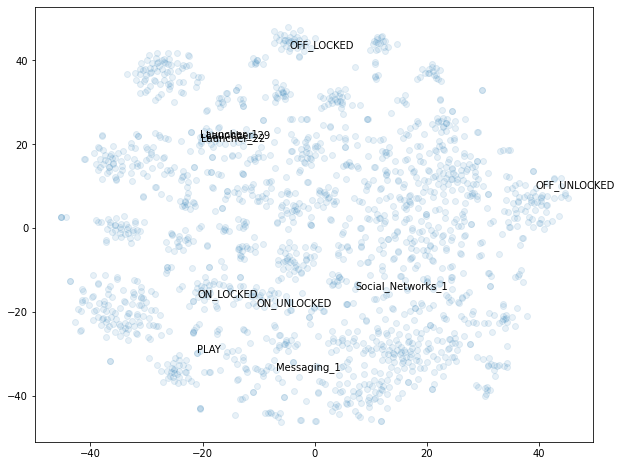

In [85]:
# plot with names of k most frequent apps
mask = df['app_name'].isin(apps_by_freq[:k])
df['labels'] = df['app_name'][mask]
df['labels'].replace(np.nan, '', regex=True, inplace=True)
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
ax.scatter(embs[:, 0], embs[:, 1], alpha=.1)
for i, label in enumerate(df['labels']):
    plt.annotate(label, (df['x'][i], df['y'][i]))